### Helpers

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import string

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
# Functions for cleaning

In [2]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
#adding fuck/bitch and shit for topic modeling
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','\'em', 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh','jd', 'je','wow','ii', 'iii', 'it','ima',
                   'imma','jr', 'js','y\'all','y\'','fuck','fucking','shit','bitch','nigga']

In [3]:
#Checking my list of stopwords
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Getting dataframes

In [4]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [5]:
print(df.shape) #(27109, 23)
df.head()

(27109, 23)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboy, old...",290,1990-00s


In [6]:
df.tail()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
27509,Drake,4PM in Calabasas,Care Package,240217,68,79,0.743,0.660,-4.802,0.418,...,0.549,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,"[selfpromoters, janky, established, like, yank...","[selfpromoters, janky, establish, like, yankee...",352,2010-20s
27510,House of Pain,The Have Nots,Truth Crushed To Earth Shall Rise Again,264066,32,79,0.686,0.420,-16.039,0.292,...,0.320,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,"[benevolence, mercy, discipline, benevolence, ...","[benevolence, mercy, discipline, benevolence, ...",211,1990-00s
27511,Future,XanaX Damage,SAVE ME,104013,61,79,0.551,0.609,-8.975,0.143,...,0.324,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,"[blood, blood, blood, xanax, dreams, xanax, co...","[blood, blood, blood, xanax, dream, xanax, cov...",88,2010-20s
27512,Three 6 Mafia,In da Game,Mystic Stylez,244133,32,79,0.671,0.889,-4.269,0.295,...,0.747,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,"[dope, game, cocaine, dope, game, dope, dope, ...","[dope, game, cocaine, dope, game, dope, dope, ...",323,1990-00s
27513,M.O.P.,Shake Em Up,Street Certified,197536,10,1,0.371,0.957,-3.475,0.382,...,0.627,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,"[glitzed, raw, hoodness, sits, car, strange, a...","[glitzed, raw, hoodness, sit, car, strange, an...",225,2010-20s


In [7]:
#new index so I can concat dataframes later
df.reset_index(inplace=True,drop=True)

In [8]:
df.tail()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
27104,Drake,4PM in Calabasas,Care Package,240217,68,79,0.743,0.660,-4.802,0.418,...,0.549,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,"[selfpromoters, janky, established, like, yank...","[selfpromoters, janky, establish, like, yankee...",352,2010-20s
27105,House of Pain,The Have Nots,Truth Crushed To Earth Shall Rise Again,264066,32,79,0.686,0.420,-16.039,0.292,...,0.320,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,"[benevolence, mercy, discipline, benevolence, ...","[benevolence, mercy, discipline, benevolence, ...",211,1990-00s
27106,Future,XanaX Damage,SAVE ME,104013,61,79,0.551,0.609,-8.975,0.143,...,0.324,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,"[blood, blood, blood, xanax, dreams, xanax, co...","[blood, blood, blood, xanax, dream, xanax, cov...",88,2010-20s
27107,Three 6 Mafia,In da Game,Mystic Stylez,244133,32,79,0.671,0.889,-4.269,0.295,...,0.747,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,"[dope, game, cocaine, dope, game, dope, dope, ...","[dope, game, cocaine, dope, game, dope, dope, ...",323,1990-00s
27108,M.O.P.,Shake Em Up,Street Certified,197536,10,1,0.371,0.957,-3.475,0.382,...,0.627,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,"[glitzed, raw, hoodness, sits, car, strange, a...","[glitzed, raw, hoodness, sit, car, strange, an...",225,2010-20s


In [9]:
#drop some columns before re-cleaning the data
df = df.drop(columns=['Album','duration_ms','tokens','tokens_lemma'])

In [10]:
df.tail()

,Artist,Title,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade
27104,Drake,4PM in Calabasas,68,79,0.743,0.660,-4.802,0.418,0.1150,0.000000,0.101,0.549,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,352,2010-20s
27105,House of Pain,The Have Nots,32,79,0.686,0.420,-16.039,0.292,0.1370,0.000000,0.120,0.320,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,211,1990-00s
27106,Future,XanaX Damage,61,79,0.551,0.609,-8.975,0.143,0.3680,0.000154,0.192,0.324,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,88,2010-20s
27107,Three 6 Mafia,In da Game,32,79,0.671,0.889,-4.269,0.295,0.2680,0.000349,0.216,0.747,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,323,1990-00s
27108,M.O.P.,Shake Em Up,10,1,0.371,0.957,-3.475,0.382,0.0736,0.000000,0.743,0.627,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,225,2010-20s


## Tokenize

In [11]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [12]:
# Convert to list
data = df.Cleaned_lyrics.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['for', 'years', 'have', 'been', 'waitin', 'and', 'hesitatin', 'to', 'make', 'rap', 'record', 'that', 'had', 'the', 'pace', 'of', 'slow', 'song', 'quiet', 'storm', 'chillin', 'while', 'the', 'fire', 'is', 'warm', 'you', 'and', 'your', 'girl', 'with', 'this', 'record', 'on', 'your', 'radio', 'or', 'stereo', 'dont', 'know', 'love', 'you', 'so', 'is', 'what', 'youll', 'be', 'sayin', 'while', 'this', 'records', 'playin', 'you', 'reminscin', 'and', 'kissin', 'your', 'girl', 'relax', 'lay', 'back', 'unwind', 'because', 'now', 'its', 'time', 'to', 'chill', 'setting', 'the', 'mood', 'by', 'the', 'use', 'of', 'this', 'groove', 'is', 'an', 'ingenious', 'perceptive', 'brilliant', 'very', 'clever', 'move', 'because', 'the', 'bass', 'line', 'combined', 'with', 'the', 'fresh', 'rhyme', 'at', 'slow', 'tempo', 'entices', 'passion', 'to', 'grow', 'but', 'if', 'its', 'not', 'passion', 'for', 'which', 'you', 'search', 'then', 'use', 'the', 'song', 'as', 'massage', 'after', 'hard', 'days', 'work', 'and',

In [13]:
len(data_words)

27109

## Build Bigram, Trigram Models and Lemmatize

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once

In [16]:
#Function to process lyrics
def process_words(texts, stop_words=stopwords_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [17]:
data_ready = process_words(data_words)  # processed all lyrics

In [18]:
data_ready[:1]

[['year',
  'make',
  'rap',
  'record',
  'pace',
  'slow',
  'song',
  'quiet_storm',
  'chillin',
  'fire',
  'warm',
  'girl',
  'record',
  'know',
  'love',
  'sayin',
  'playin',
  'relax',
  'lie',
  'back',
  'unwind',
  'time',
  'chill',
  'set',
  'mood',
  'use',
  'groove',
  'ingenious',
  'perceptive',
  'brilliant',
  'clever',
  'bass',
  'line',
  'combine',
  'fresh',
  'rhyme',
  'slow',
  'tempo',
  'entice',
  'passion',
  'grow',
  'passion',
  'search',
  'use',
  'song',
  'massage',
  'hard',
  'day',
  'work',
  'true',
  'music',
  'calm',
  'savage',
  'beast',
  'play',
  'cut',
  'jungle',
  'put',
  'lion',
  'sleep',
  'take',
  'deep',
  'breath',
  'footwear',
  'put',
  'tape',
  'record',
  'beware',
  'caution_warning',
  'decision',
  'nothing',
  'strong',
  'buy',
  'prescription',
  'soothe',
  'somewhat',
  'hypnotic',
  'rhythmic',
  'anesthetic',
  'practically',
  'narcotic',
  'want',
  'get',
  'come',
  'widdit',
  'push',
  'hit',
  'o

## Build the Topic Model

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [21]:
#check the topic
for topic in lda_model.print_topics():
    print(topic)
    print("--------")
# print(lda_model.print_topics())

(0, '0.020*"never" + 0.016*"life" + 0.013*"see" + 0.011*"time" + 0.010*"make" + 0.010*"feel" + 0.009*"live" + 0.008*"say" + 0.008*"day" + 0.008*"think"')
--------
(1, '0.038*"get" + 0.013*"come" + 0.009*"make" + 0.009*"back" + 0.009*"man" + 0.008*"go" + 0.007*"run" + 0.007*"put" + 0.006*"hit" + 0.006*"know"')
--------
(2, '0.048*"know" + 0.046*"get" + 0.045*"go" + 0.026*"say" + 0.024*"let" + 0.020*"girl" + 0.018*"love" + 0.018*"tell" + 0.018*"baby" + 0.018*"come"')
--------
(3, '0.079*"get" + 0.037*"money" + 0.012*"smoke" + 0.012*"big" + 0.011*"high" + 0.009*"drink" + 0.009*"hoe" + 0.008*"boy" + 0.008*"hit" + 0.008*"cash"')
--------


## Dominant topic and its percentage contribution in each lyric

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [23]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [24]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4806,"never, life, see, time, make, feel, live, say,...","[year, make, rap, record, pace, slow, song, qu..."
1,1,0.0,0.4289,"never, life, see, time, make, feel, live, say,...","[big, know, go, know, keep, candy, need, mandy..."
2,2,0.0,0.6033,"never, life, see, time, make, feel, live, say,...","[harsh, reality, life, take, toll, even, forsa..."
3,3,1.0,0.7928,"get, come, make, back, man, go, run, put, hit,...","[give, shoutout, chorus, give, buckbuck, front..."
4,4,1.0,0.6799,"get, come, make, back, man, go, run, put, hit,...","[beat, beat, beat, go, homeboy, old, school, w..."
5,5,1.0,0.4780,"get, come, make, back, man, go, run, put, hit,...","[switch, cd, throw, whip, window, clog, clog, ..."
6,6,1.0,0.7152,"get, come, make, back, man, go, run, put, hit,...","[day, time, hold, head, lose, mind, sometimes,..."
7,7,1.0,0.3611,"get, come, make, back, man, go, run, put, hit,...","[sunshine, fool, say, never, rain, tell, true,..."
8,8,1.0,0.3800,"get, come, make, back, man, go, run, put, hit,...","[kid, corner, go, go, look, give, watch, dude,..."
9,9,1.0,0.4291,"get, come, make, back, man, go, run, put, hit,...","[go, flame, night, burn, brighter, go, flame, ..."


In [25]:
#Let's have a look
df_dominant_topic.shape

(27109, 5)

In [29]:
df_dominant_topic.Dominant_Topic.value_counts(normalize=True)

1.0    0.378841
0.0    0.264783
2.0    0.243498
3.0    0.112878
Name: Dominant_Topic, dtype: float64

In [30]:
df.shape

(27109, 19)

## Topic EDA (short)

In [31]:
#combine everything - with initial DF
full_df = pd.concat([df,df_topic_sents_keywords], axis=1)

In [32]:
full_df.tail()

,Artist,Title,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
27104,Drake,4PM in Calabasas,68,79,0.743,0.660,-4.802,0.418,0.1150,0.000000,...,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,352,2010-20s,0.0,0.4712,"never, life, see, time, make, feel, live, say,...","[selfpromoter, establish, yankee, whole, fucki..."
27105,House of Pain,The Have Nots,32,79,0.686,0.420,-16.039,0.292,0.1370,0.000000,...,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,211,1990-00s,0.0,0.3916,"never, life, see, time, make, feel, live, say,...","[come, come, come, pain, uplift, soul, get, ho..."
27106,Future,XanaX Damage,61,79,0.551,0.609,-8.975,0.143,0.3680,0.000154,...,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,88,2010-20s,2.0,0.5424,"know, get, go, say, let, girl, love, tell, bab...","[blood, blood, blood, dream, cover, blood, sun..."
27107,Three 6 Mafia,In da Game,32,79,0.671,0.889,-4.269,0.295,0.2680,0.000349,...,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,323,1990-00s,1.0,0.5781,"get, come, make, back, man, go, run, put, hit,...","[go, click, kind, punke, look, decieve, better..."
27108,M.O.P.,Shake Em Up,10,1,0.371,0.957,-3.475,0.382,0.0736,0.000000,...,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,225,2010-20s,1.0,0.6168,"get, come, make, back, man, go, run, put, hit,...","[glitze, raw, hoodness, sit, car, strange, ang..."


In [65]:
#Testing
full_df[full_df['Artist']=='NAS'].Dominant_Topic.value_counts()

Series([], Name: Dominant_Topic, dtype: int64)

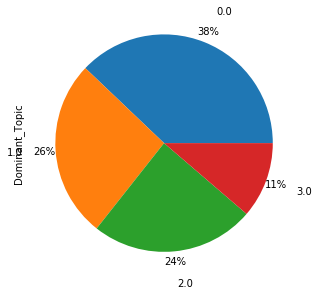

In [72]:
full_df.Dominant_Topic.value_counts().plot.pie(figsize=(5, 5),labels=full_df.Dominant_Topic.unique(), 
                                               autopct='%2.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show()

### Evolution of topics over the years

In [52]:
#Create a DF with year and topic
topic_year = pd.DataFrame(full_df.groupby("Year_release")['Dominant_Topic'].value_counts())

In [56]:
topic_year.columns=['Value']

In [57]:
topic_year.head()

Value
Year_release Dominant_Topic       
1979.0       2.0                 1
1980.0       2.0                 8
             0.0                 2
1981.0       0.0                 1
             1.0                 1

In [ ]:
## Select 1988+

In [145]:
topic_year_88 = topic_year.loc[1988:]

In [146]:
topic_year_88

Value
Year_release Dominant_Topic       
1988.0       1.0                56
             0.0                17
             2.0                12
             3.0                 1
1989.0       1.0                71
...                            ...
2018.0       3.0               310
2019.0       2.0               297
             0.0               277
             1.0               203
             3.0               169

[126 rows x 1 columns]

In [149]:
topic_year_88 = topic_year_88.unstack()

In [151]:
topic_year_88.head()

Value                  
Dominant_Topic   0.0    1.0   2.0  3.0
Year_release                          
1988.0          17.0   56.0  12.0  1.0
1989.0          27.0   71.0  20.0  NaN
1990.0          15.0   63.0  23.0  1.0
1991.0          37.0  105.0  37.0  NaN
1992.0          20.0  113.0  20.0  2.0

In [159]:
topic_year_88.columns = Topics

In [160]:
topic_year_88.head()

,Hip-Hop Life and violence,Life and Universe,Love and Relationship,"Money, Drugs and Sex"
Year_release,,,,
1988.0,17.0,56.0,12.0,1.0
1989.0,27.0,71.0,20.0,NaN
1990.0,15.0,63.0,23.0,1.0
1991.0,37.0,105.0,37.0,NaN
1992.0,20.0,113.0,20.0,2.0


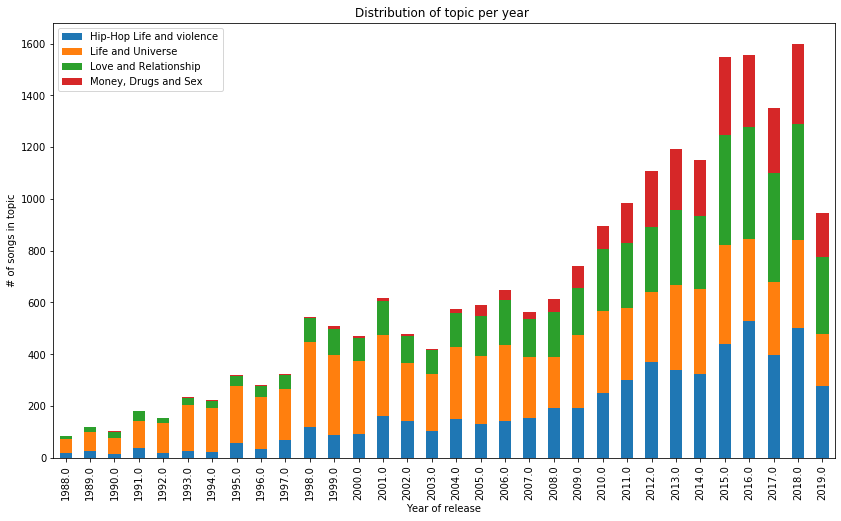

In [165]:

data = topic_year_88

axes = data.plot(kind='bar', stacked=True,figsize=(14,8))
axes.set_title('Distribution of topic per year ')
axes.set_xlabel("Year of release")
axes.set_ylabel("# of songs in topic")
plt.legend()
plt.show()

## The most representative lyric for each topic

In [73]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9941,"never, life, see, time, make, feel, live, say, day, think","[happy, day, happy, day, happy, day, happy, day, jesus_washe, wash, jesus_washed, wash, jesus_wa..."
1,1.0,0.9938,"get, come, make, back, man, go, run, put, hit, know","[south_memphis_w, south_memphis_w, south_memphis_w, south_memphis_w, south_memphis_w, slap, punk..."
2,2.0,0.9885,"know, get, go, say, let, girl, love, tell, baby, come","[know, wait, wait, wait, special, girl, girl, know, girl, wait, boy, eskiboy, way, move, right, ..."
3,3.0,0.9654,"get, money, smoke, big, high, drink, hoe, boy, hit, cash","[smoke, drink, pop, smoke, drink, pop, oohah, smoke, drink, pop, smoke, drink, pop, oohah, smoke..."


## Frequency Distribution of Word Counts in Lyrics

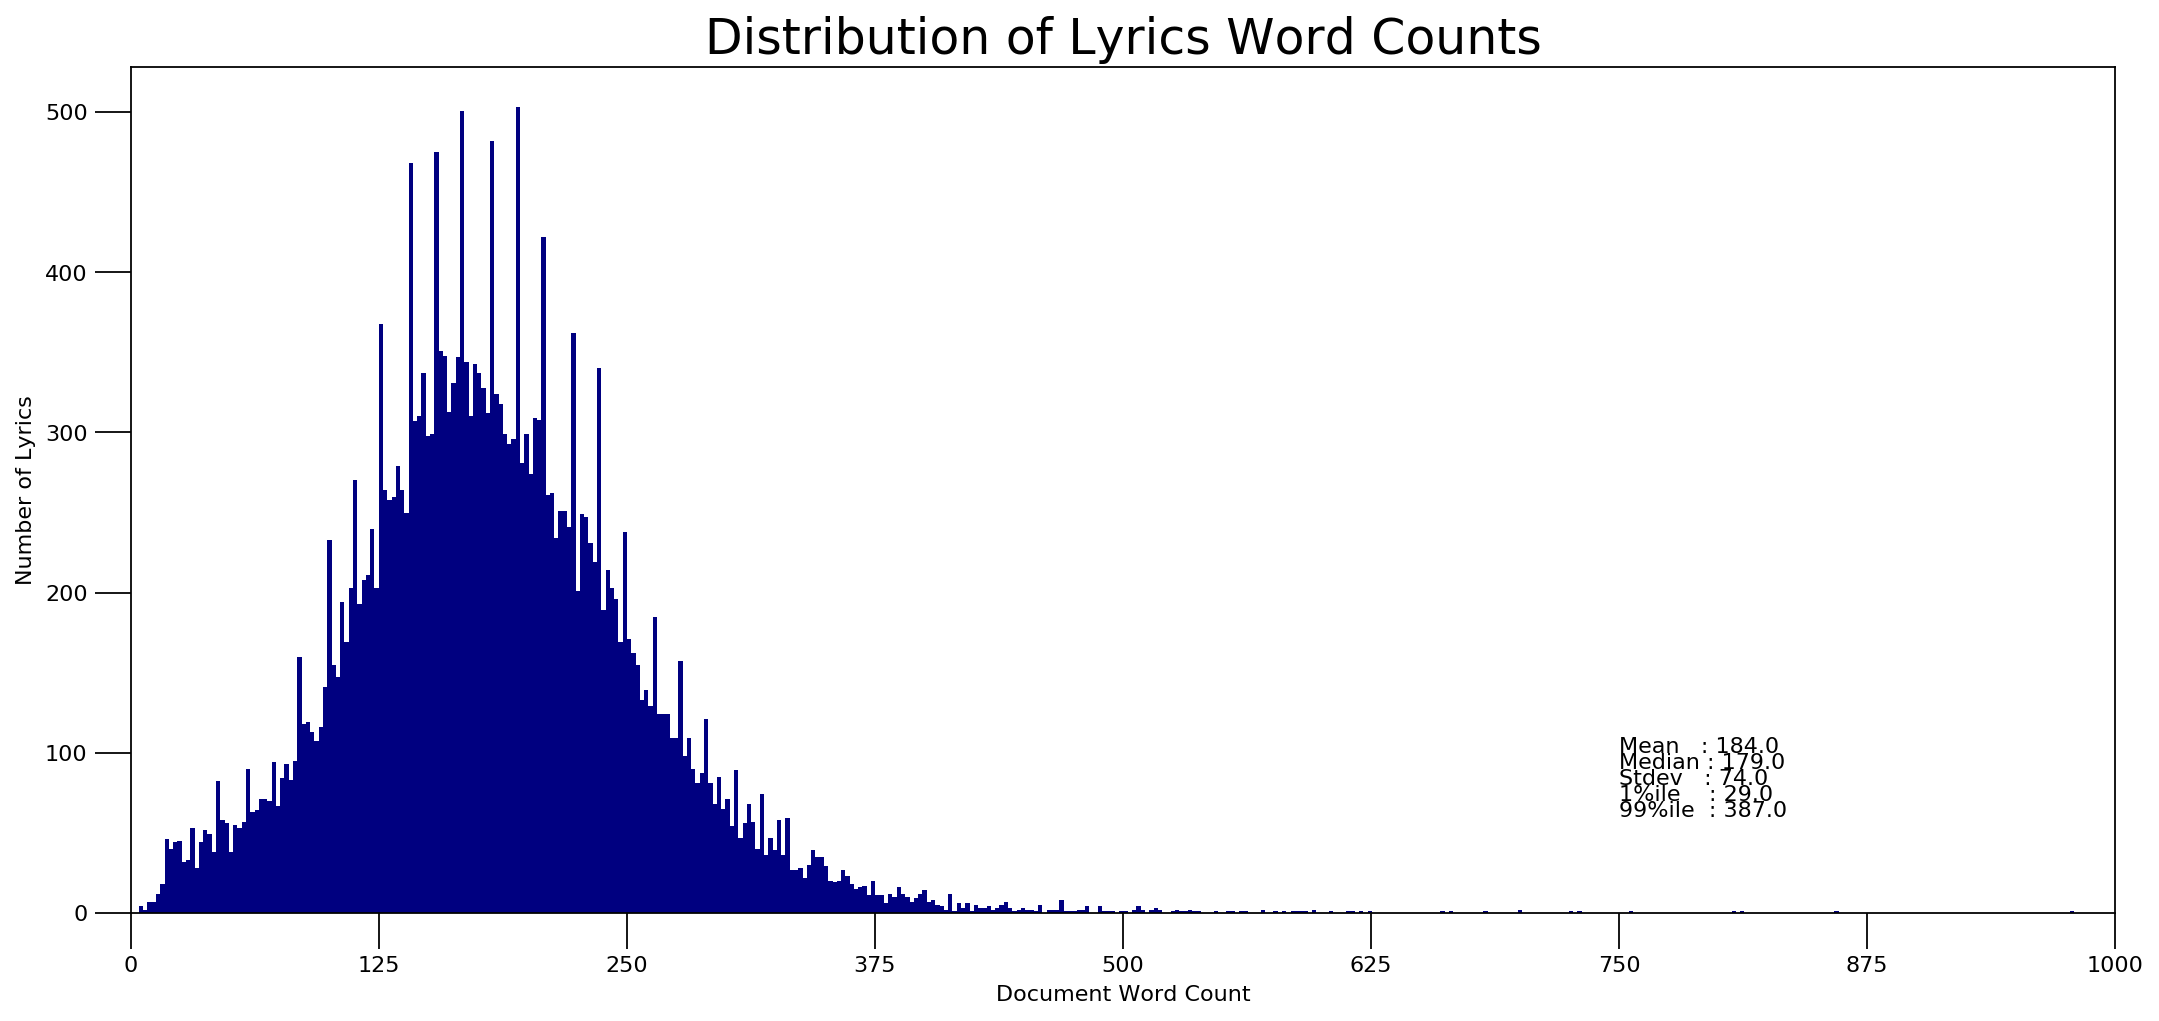

In [75]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Lyrics', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Lyrics Word Counts', fontdict=dict(size=22))
plt.show()

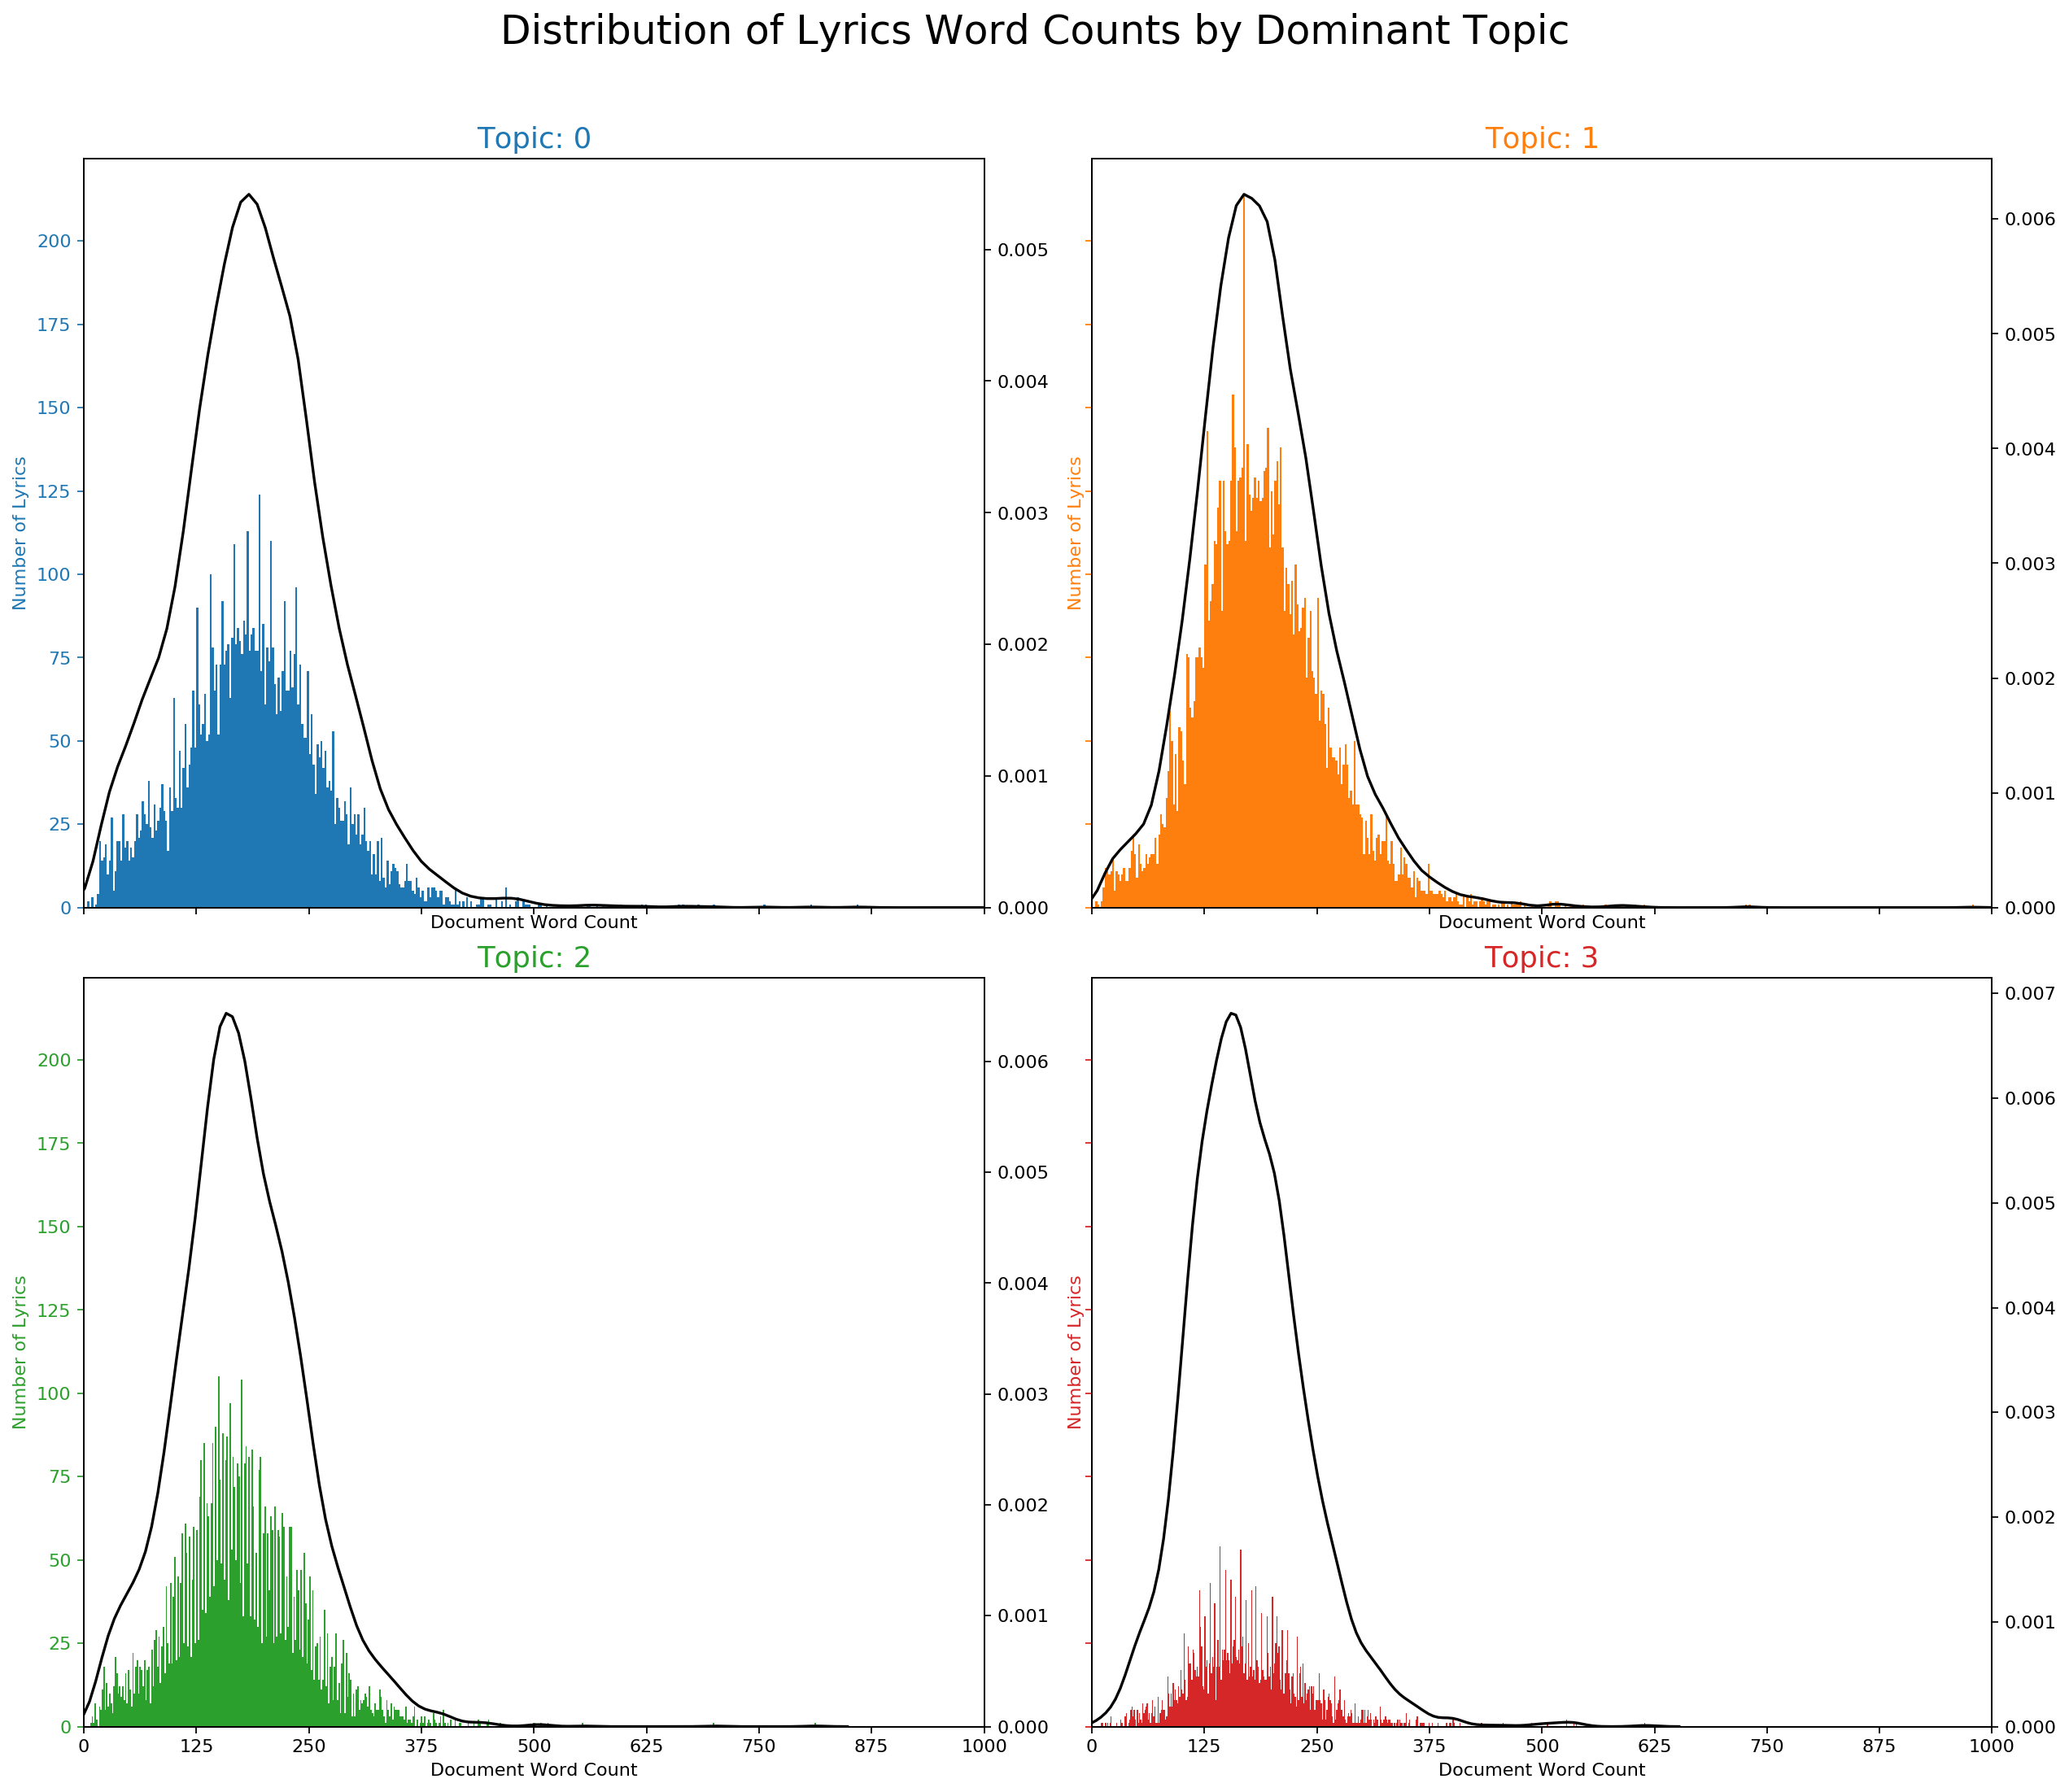

In [78]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 500, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Lyrics', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Lyrics Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
# 4 topic might be ok

## Word Clouds of Top 25 Keywords in Each Topic

In [83]:
mcolors.XKCD_COLORS.items()

dict_items([('xkcd:cloudy blue', '#acc2d9'), ('xkcd:dark pastel green', '#56ae57'), ('xkcd:dust', '#b2996e'), ('xkcd:electric lime', '#a8ff04'), ('xkcd:fresh green', '#69d84f'), ('xkcd:light eggplant', '#894585'), ('xkcd:nasty green', '#70b23f'), ('xkcd:really light blue', '#d4ffff'), ('xkcd:tea', '#65ab7c'), ('xkcd:warm purple', '#952e8f'), ('xkcd:yellowish tan', '#fcfc81'), ('xkcd:cement', '#a5a391'), ('xkcd:dark grass green', '#388004'), ('xkcd:dusty teal', '#4c9085'), ('xkcd:grey teal', '#5e9b8a'), ('xkcd:macaroni and cheese', '#efb435'), ('xkcd:pinkish tan', '#d99b82'), ('xkcd:spruce', '#0a5f38'), ('xkcd:strong blue', '#0c06f7'), ('xkcd:toxic green', '#61de2a'), ('xkcd:windows blue', '#3778bf'), ('xkcd:blue blue', '#2242c7'), ('xkcd:blue with a hint of purple', '#533cc6'), ('xkcd:booger', '#9bb53c'), ('xkcd:bright sea green', '#05ffa6'), ('xkcd:dark green blue', '#1f6357'), ('xkcd:deep turquoise', '#017374'), ('xkcd:green teal', '#0cb577'), ('xkcd:strong pink', '#ff0789'), ('xkcd:

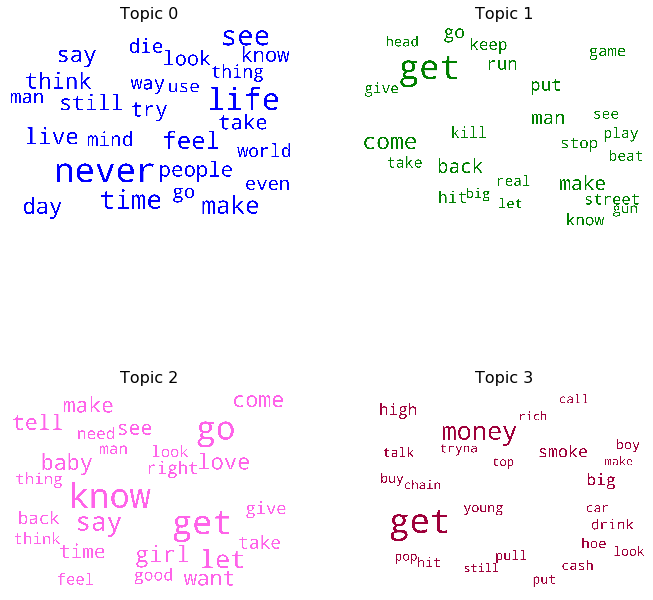

<Figure size 432x288 with 0 Axes>

In [167]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS - mcolors.TABLEAU_COLORS'

cols = ['blue','green','#ff63e9','#9e003a']
cloud = WordCloud(stopwords=stopwords_list,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_words=25)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=-3, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig('topic_wordcloud.png')

## Topics labeling

In [129]:
Topics = ['Hip-Hop Life and violence', 'Life and Universe', 'Love and Relationship', 'Money, Drugs and Sex']

In [130]:
for index,topic in enumerate(Topics):
    print('Topic '+str(index)+ ': '+topic)

Topic 0: Hip-Hop Life and violence
Topic 1: Life and Universe
Topic 2: Love and Relationship
Topic 3: Money, Drugs and Sex


## Word Counts of Topic Keywords

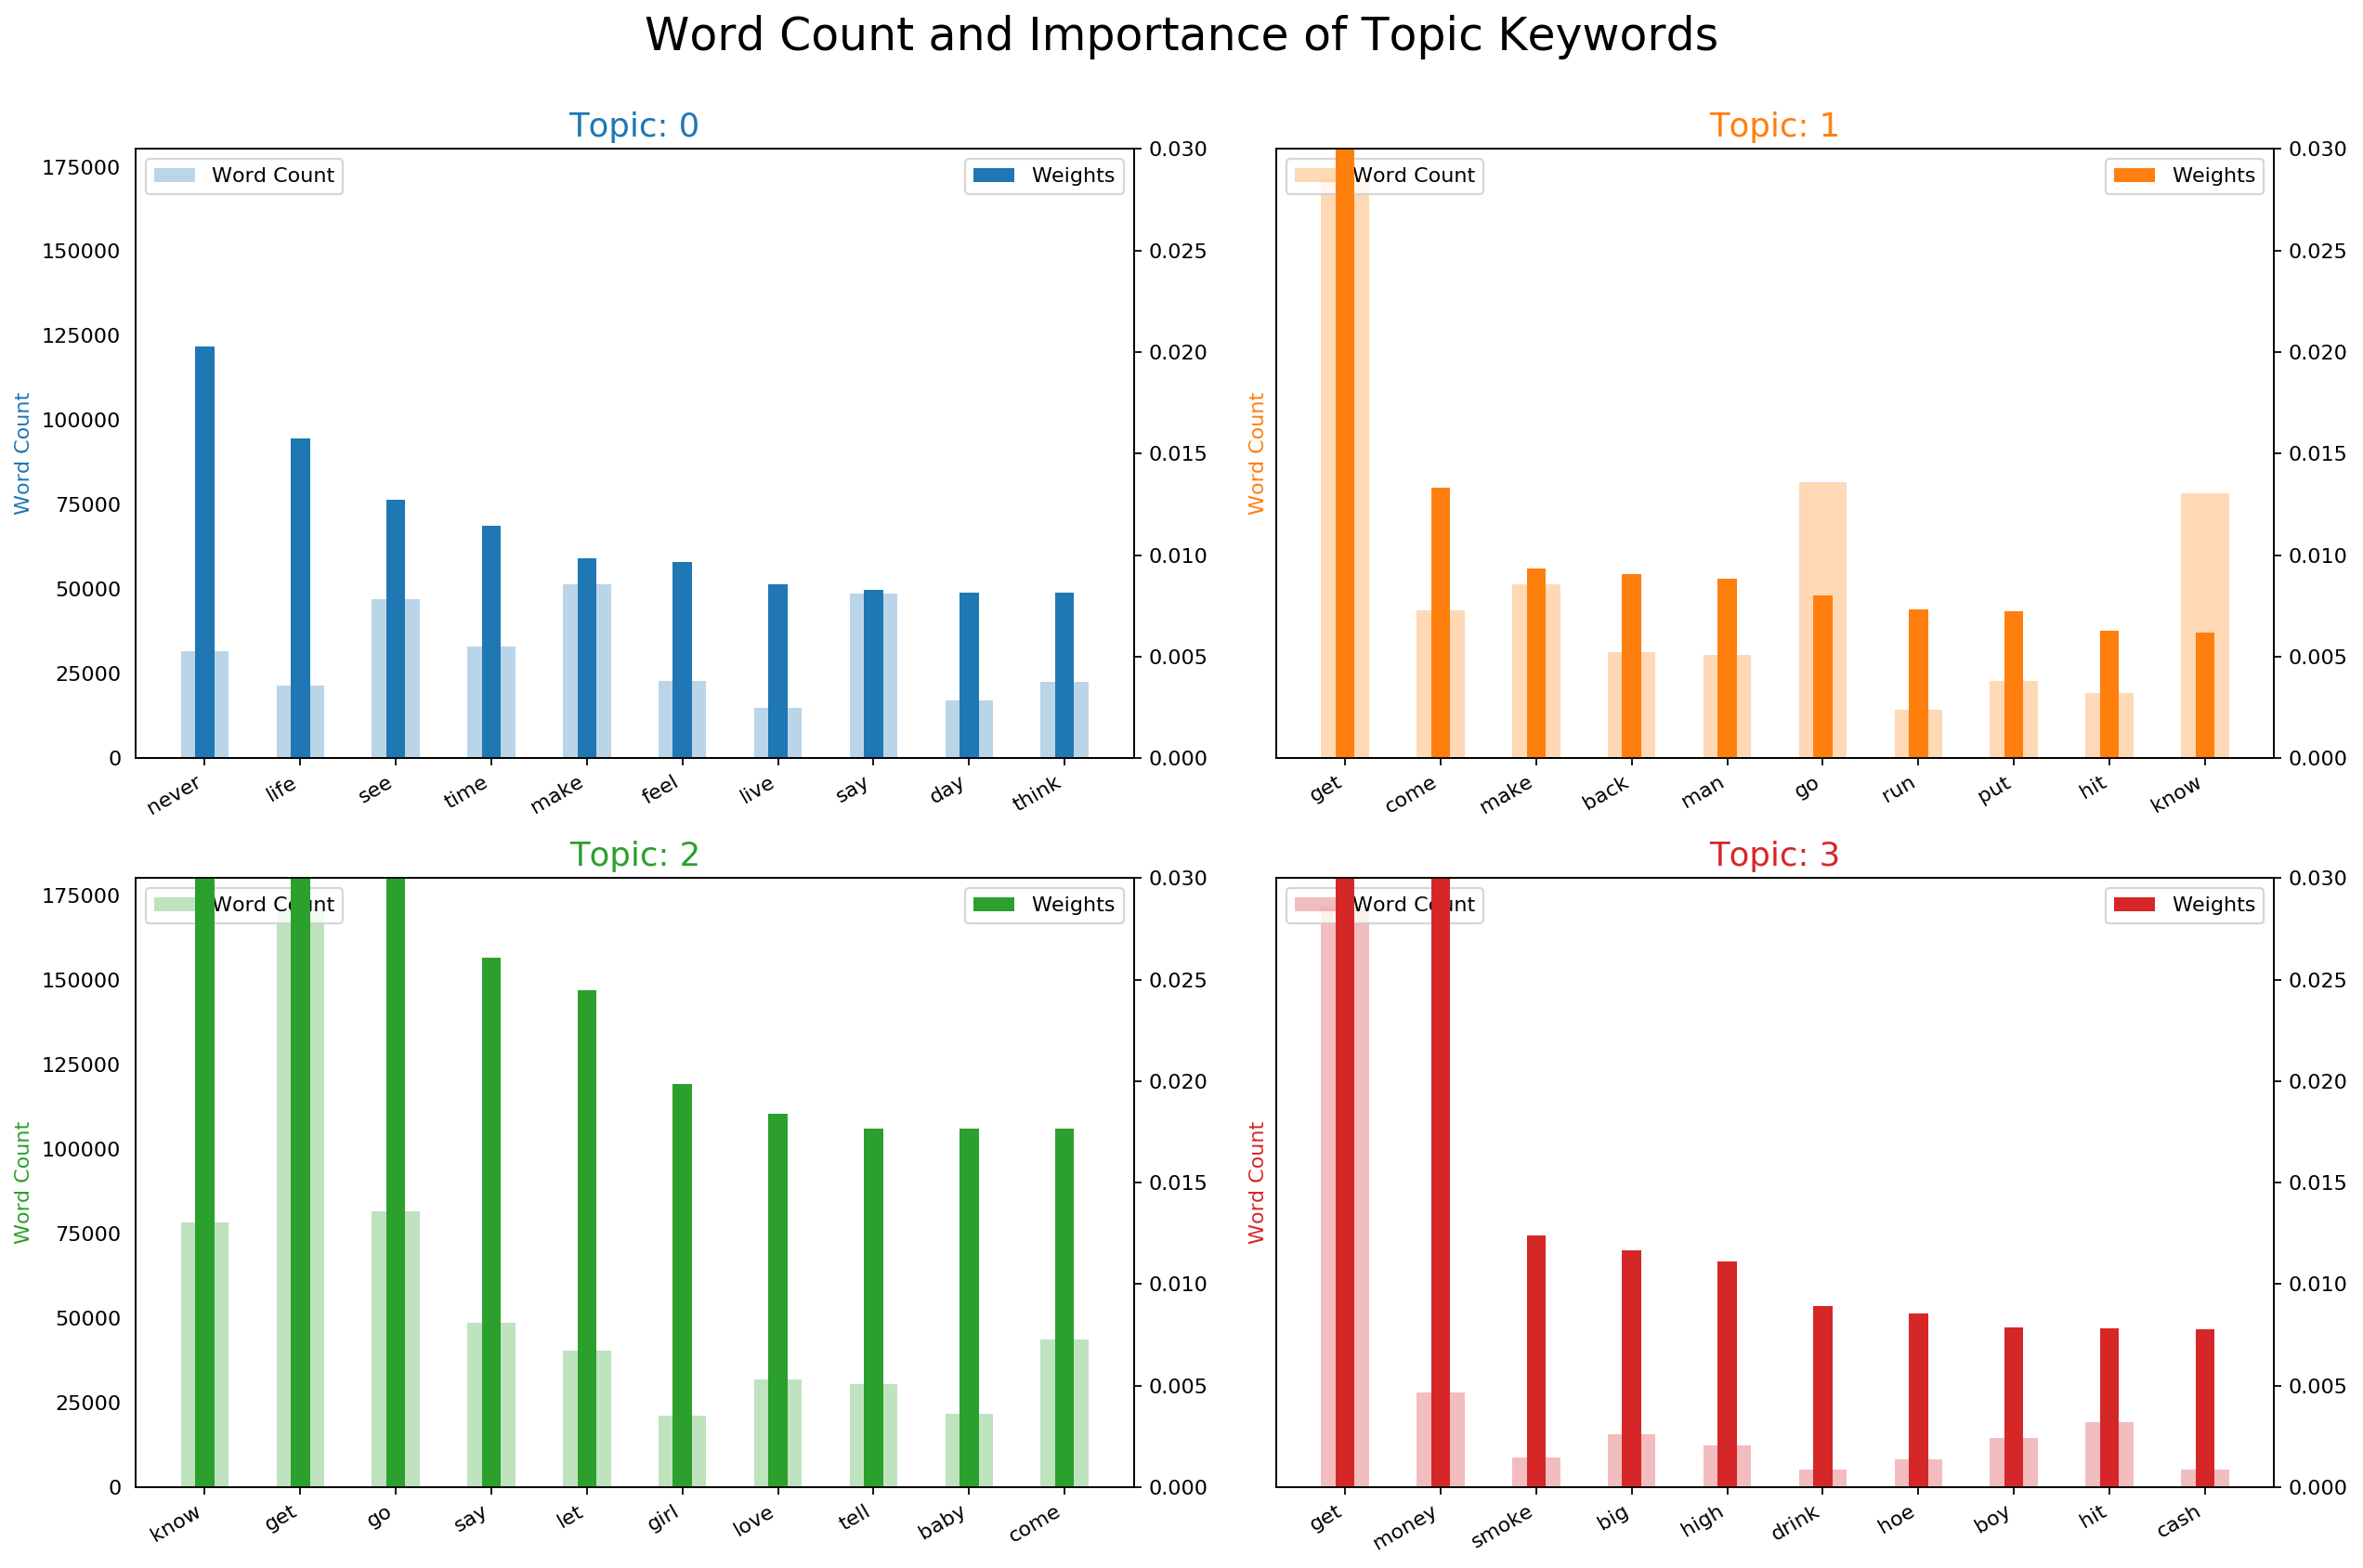

In [100]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_2.loc[df_2.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_2.loc[df_2.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030);
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_2.loc[df_2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Most discussed topic

In [101]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df_3 = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df_3.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [123]:
df_dominant_topic_in_each_doc.head()

,Dominant_Topic,count
0,0,7178
1,1,10269
2,2,6601
3,3,3060


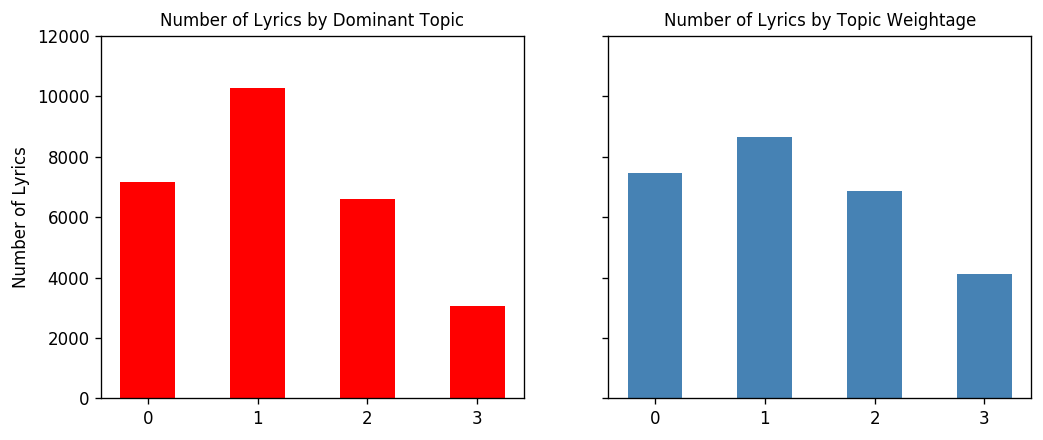

In [119]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='red')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
# tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Lyrics by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Lyrics')
ax1.set_ylim(0, 12000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
# ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Lyrics by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [103]:
df_dominant_topic.Dominant_Topic.value_counts()

1.0    10270
0.0     7178
2.0     6601
3.0     3060
Name: Dominant_Topic, dtype: int64

## t-SNE Clustering Chart

In [104]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24976 samples in 0.008s...
[t-SNE] Computed neighbors for 24976 samples in 0.543s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24976
[t-SNE] Computed conditional probabilities for sample 2000 / 24976
[t-SNE] Computed conditional probabilities for sample 3000 / 24976
[t-SNE] Computed conditional probabilities for sample 4000 / 24976
[t-SNE] Computed conditional probabilities for sample 5000 / 24976
[t-SNE] Computed conditional probabilities for sample 6000 / 24976
[t-SNE] Computed conditional probabilities for sample 7000 / 24976
[t-SNE] Computed conditional probabilities for sample 8000 / 24976
[t-SNE] Computed conditional probabilities for sample 9000 / 24976
[t-SNE] Computed conditional probabilities for sample 10000 / 24976
[t-SNE] Computed conditional probabilities for sample 11000 / 24976
[t-SNE] Computed conditional probabilities for sample 12000 / 24976
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [105]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/fabricemesidor/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.062823  0.198115       1        1  32.471294
0      0.231134 -0.119471       2        1  28.062185
2      0.071857  0.067855       3        1  24.627001
3     -0.240167 -0.146499       4        1  14.839518, topic_info=    Category           Freq   Term          Total  loglift  logprob
52   Default  177615.000000    get  177615.000000  30.0000  30.0000
690  Default   28814.000000  money   28814.000000  29.0000  29.0000
70   Default   78898.000000   know   78898.000000  28.0000  28.0000
167  Default   78357.000000     go   78357.000000  27.0000  27.0000
53   Default   24393.000000   girl   24393.000000  26.0000  26.0000
..       ...            ...    ...            ...      ...      ...
396   Topic4    3901.304443    new    8606.224609   1.1167  -5.2461
318   Topic4    4286.561523  still   20278.552734   0.3538  -5.1520
79    Topic4    4272.623047   make   53936.976562  -0.6277  -5.1552
332   Topic4    3864.685547   tell   31867.115234  -0.2018  -5.2556
305   Topic4    3848.765869    see   48268.164062  -0.6211  -5.2597

[324 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
192       2  0.999740   alive
349       2  0.999732  answer
351       1  0.526884     ass
351       3  0.274020     ass
351       4  0.199103     ass
...     ...       ...     ...
602       2  0.840096   write
1749      4  0.999068  yellow
1277      2  0.281192   young
1277      3  0.020626   young
1277      4  0.698221   young

[485 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

## Clustering with topics

Topic 0: Hip-Hop Culture and violence
Topic 1: Life and universe
Topic 2: Love and relationship
Topic 3: Money, drugs and sex
